# **Install & Import Library**

**Install**

**TensorFlow.js**

In [1]:
!pip install tensorflowjs

**Kaggle**

In [2]:
!pip install kaggle

**Import**

In [3]:
import os
import shutil
import zipfile
import pathlib

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

In [4]:
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.15.0


# **Data Preparation**

**Data Collecting**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!mkdir ~/.kaggle

In [7]:
!cp /content/drive/MyDrive/RPLL/kaggle.json ~/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download virgiawan/12-classes-garbage-classification

 97% 78.0M/80.6M [00:04<00:00, 27.4MB/s]
100% 80.6M/80.6M [00:04<00:00, 18.2MB/s]


In [10]:
local_zip = '/content/12-classes-garbage-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [11]:
PATH = '/content/garbage_classification'
PATH

'/content/garbage_classification'

In [12]:
data_dir = pathlib.Path(PATH)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total image from this datasets : {image_count}')

print(f'\nDistribution Image')
for i, label in enumerate(os.listdir(data_dir)):
  label_dir = os.path.join(data_dir, label)
  len_label_dir = len(os.listdir(label_dir))
  print(f'{i+1}. {label} : {len_label_dir}')

Total image from this datasets : 7692

Distribution Image
1. clothes : 645
2. biological : 648
3. shoes : 647
4. cardboard : 643
5. white-glass : 645
6. paper : 645
7. trash : 647
8. green-glass : 629
9. brown-glass : 607
10. battery : 642
11. metal : 649
12. plastic : 645


# **Data Preprocessing & Transformation**

**Set Up Parameters**

In [13]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

np.random.seed(123)
seed = np.random.randint(0,100)
print(f"Current seed : {seed}")

Current seed : 66


**Load data using a Keras utility**

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 7692 files belonging to 12 classes.
Using 6154 files for training.
Found 7692 files belonging to 12 classes.
Using 1538 files for validation.


In [15]:
class_names = train_ds.class_names
class_names_val = val_ds.class_names

print(f'List label Train data: \n{class_names}\n')
print(f'List label Validation data: \n{class_names_val}')

List label Train data: 
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

List label Validation data: 
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


**Check image batch**

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


**Plot Data**

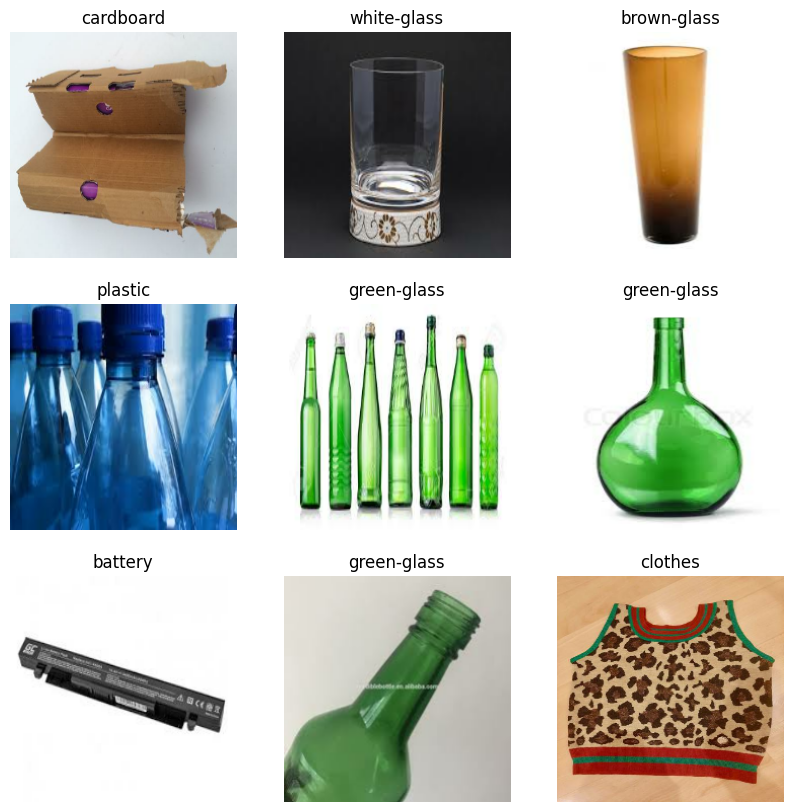

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")







**Split validation data to test data**

In [18]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 40
Number of test batches: 9


**configure data performance for training**

In [19]:

AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

train_ds = train_ds.cache().shuffle(image_count//4).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# **Create Layer & Model**

## **Layer**

Data Augmentation Layer



In [20]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  # tf.keras.layers.RandomZoom(0.2)],
  tf.keras.layers.RandomZoom(0.1)],
  name="data_augmentation")

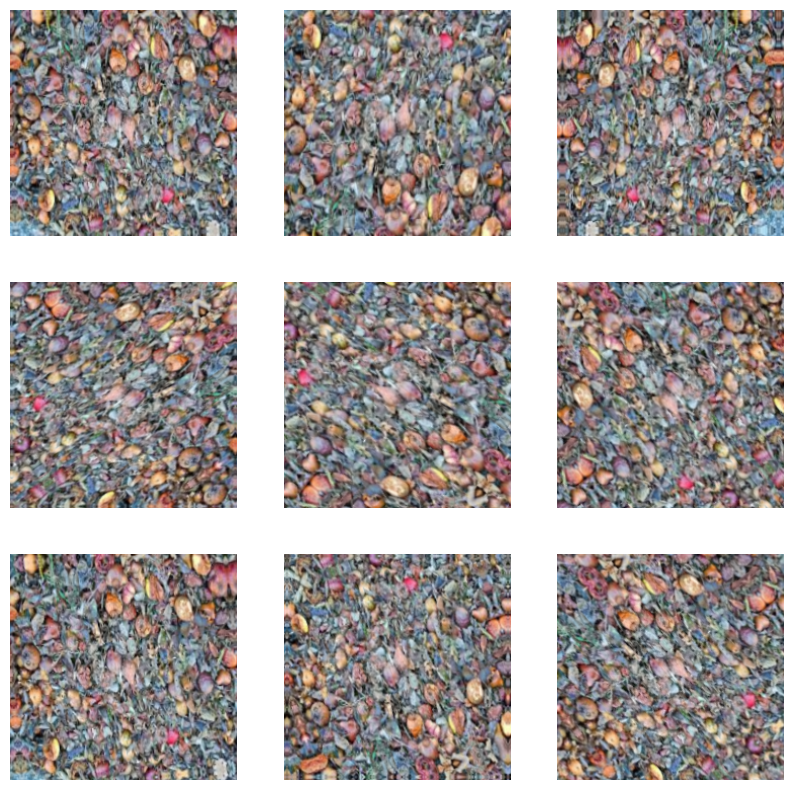

In [21]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Rescale Pixel Layer

In [22]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

Global Average Layer

In [23]:

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Base Model Layer

In [24]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


Freeze Base Model

In [25]:
base_model.trainable = False

Input Layer

In [26]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

# **Model**

Model Builder

In [27]:
def model_builder():

  # Number Classes from data
  num_classes = len(class_names)

  # Create Model Sequential keras
  model = tf.keras.Sequential()

  # Add Custom Layer
  model.add(inputs)
  model.add(data_augmentation)
  model.add(normalization_layer)
  model.add(base_model)
  model.add(global_average_layer)

  # Add fully connected layer with dropout
  model.add(tf.keras.layers.Dense(units=512, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.2))

  # Prediction Layer
  model.add(tf.keras.layers.Dense(num_classes,
                                  activation='softmax',
                                  name="final_output"))

  base_learning_rate = 1e-3
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

  return model

# **Train, Eval & Test Model**

**Train**

Define Callbacks

In [28]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint_model.h5",
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10,
                                                  mode ="max",
                                                  verbose=2,
                                                  restore_best_weights=True)

Checking Model

In [29]:
model = model_builder()
print(f"Model : {model}")

Model : <keras.src.engine.sequential.Sequential object at 0x78a78d9334f0>


Model Training

In [30]:
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
193/193 [==============================] - ETA: 0s - loss: 0.8021 - accuracy: 0.7444
Epoch 1: val_accuracy improved from -inf to 0.84800, saving model to checkpoint_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


193/193 [==============================] - 436s 2s/step - loss: 0.8021 - accuracy: 0.7444 - val_loss: 0.4399 - val_accuracy: 0.8480
Epoch 2/100
193/193 [==============================] - ETA: 0s - loss: 0.4896 - accuracy: 0.8380
Epoch 2: val_accuracy improved from 0.84800 to 0.87360, saving model to checkpoint_model.h5
193/193 [==============================] - 412s 2s/step - loss: 0.4896 - accuracy: 0.8380 - val_loss: 0.3889 - val_accuracy: 0.8736
Epoch 3/100
193/193 [==============================] - ETA: 0s - loss: 0.4189 - accuracy: 0.8590
Epoch 3: val_accuracy improved from 0.87360 to 0.87680, saving model to checkpoint_model.h5
193/193 [==============================] - 376s 2s/step - loss: 0.4189 - accuracy: 0.8590 - val_loss: 0.3474 - val_accuracy: 0.8768
Epoch 4/100
193/193 [==============================] - ETA: 0s - loss: 0.3528 - accuracy: 0.8791
Epoch 4: val_accuracy improved from 0.87680 to 0.87920, saving model to checkpoint_model.h5
193/193 [============================

**Eval**

Plot Result

In [31]:
%matplotlib inline
plt.style.use('seaborn')

<ipython-input-31-447fa776aed2>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


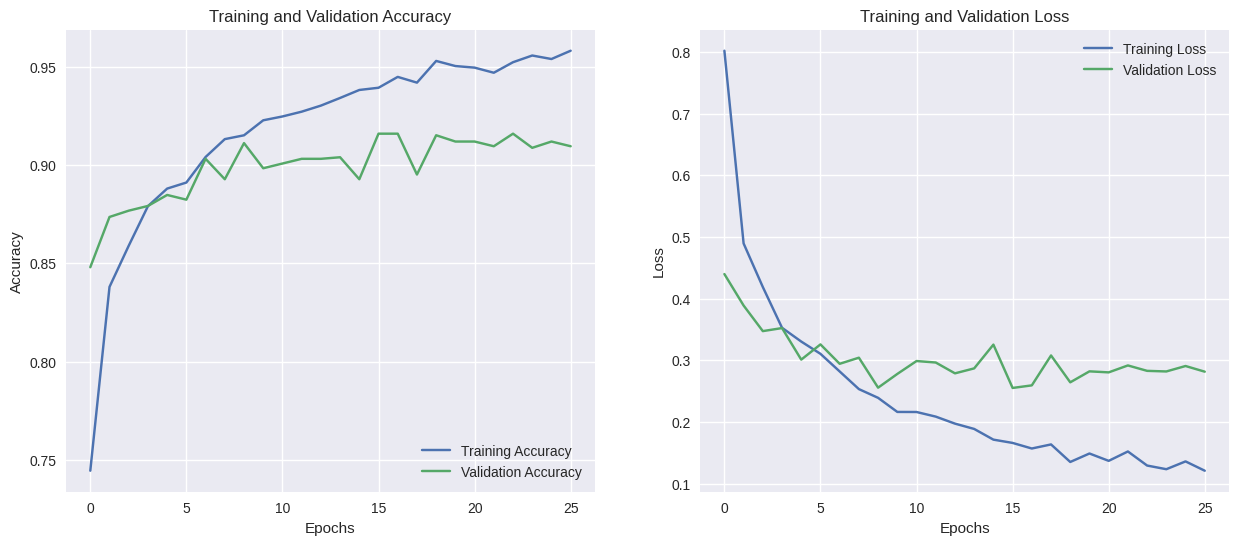

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Evaluate Model Performance

In [33]:
load_model = tf.keras.models.load_model('checkpoint_model.h5')
load_model.evaluate(x=test_dataset, return_dict=True)

9/9 [==============================] - 17s 2s/step - loss: 0.2800 - accuracy: 0.9132


{'loss': 0.2799524962902069, 'accuracy': 0.9131944179534912}

**Test**

Change format to ndarray

In [34]:
class_names = np.array(class_names)
class_names_val = np.array(class_names_val)

print(f'List label Train data: \n{class_names}\n')
print(f'List label Validation data: \n{class_names_val}')

List label Train data: 
['battery' 'biological' 'brown-glass' 'cardboard' 'clothes' 'green-glass'
 'metal' 'paper' 'plastic' 'shoes' 'trash' 'white-glass']

List label Validation data: 
['battery' 'biological' 'brown-glass' 'cardboard' 'clothes' 'green-glass'
 'metal' 'paper' 'plastic' 'shoes' 'trash' 'white-glass']


In [35]:
image_batch_test, label_batch_test = next(iter(test_dataset))

image_batch_test, label_batch_test = image_batch_test.numpy(), label_batch_test.numpy()


predicted_batch = load_model.predict(image_batch_test)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

1/1 [==============================] - 5s 5s/step
['green-glass' 'green-glass' 'white-glass' 'plastic' 'battery'
 'white-glass' 'trash' 'green-glass' 'paper' 'paper' 'trash' 'clothes'
 'green-glass' 'brown-glass' 'cardboard' 'metal' 'battery' 'shoes' 'trash'
 'metal' 'clothes' 'metal' 'battery' 'paper' 'white-glass' 'clothes'
 'plastic' 'clothes' 'trash' 'white-glass' 'shoes' 'plastic']


In [36]:
print(f"Labels:\n{label_batch_test}")
print(f"Predicted labels:\n{predicted_ids}")

true_predict = 0
false_predict = 0

for i in predicted_ids:
  if i in label_batch_test:
    true_predict +=1
  else:
    false_predict +=1

print()
print(f'True Predict Count : {true_predict}')
print(f'False Predict Count : {false_predict}')

Labels:
[ 5  9 11  8  0 11 10  5  7  7 10  4  5  2  7  6  0  9 10  6  4  6  0  7
 11  4 11  3 10 11  9  8]
Predicted labels:
[ 5  5 11  8  0 11 10  5  7  7 10  4  5  2  3  6  0  9 10  6  4  6  0  7
 11  4  8  4 10 11  9  8]

True Predict Count : 32
False Predict Count : 0


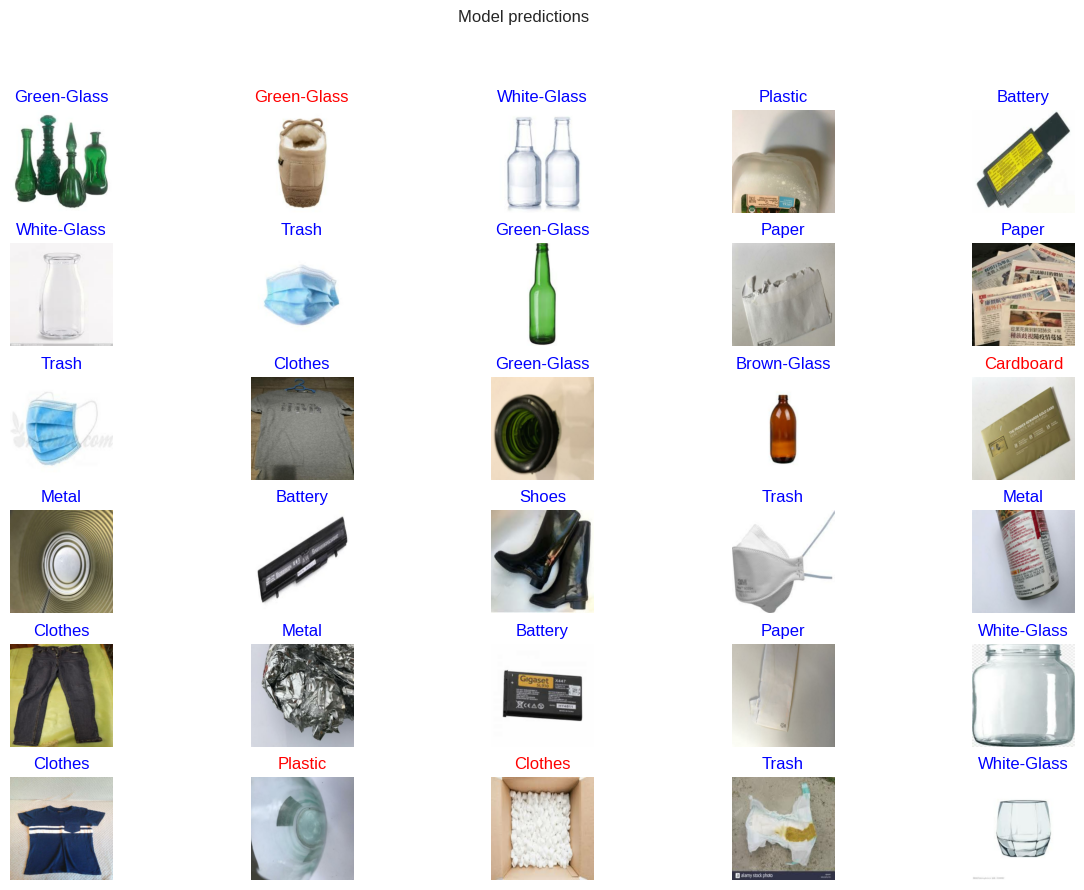

In [37]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n].astype('uint8'))
  color = "blue" if predicted_ids[n] == label_batch_test[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions")



# **Testing model with sklearn.metrics**

Set up parameters x_test and y_test

In [38]:
x_test = []
y_test = []

for x_batch, y_batch in test_dataset:
  for x_i, y_i in zip(x_batch, y_batch):
    x_test.append(x_i)
    y_test.append(y_i)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [39]:
from sklearn.metrics import accuracy_score

pred=np.argmax(model.predict(x_test), axis=-1)
accuracy = accuracy_score(y_test, pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

9/9 [==============================] - 21s 2s/step
Accuracy: 93.40%


In [40]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        26
           2       0.85      0.92      0.88        24
           3       1.00      0.86      0.93        22
           4       0.97      1.00      0.98        30
           5       0.84      0.94      0.89        17
           6       0.88      0.92      0.90        25
           7       0.89      1.00      0.94        17
           8       0.88      0.91      0.89        23
           9       0.96      0.88      0.92        26
          10       1.00      0.96      0.98        27
          11       0.89      0.76      0.82        21

    accuracy                           0.93       288
   macro avg       0.93      0.93      0.93       288
weighted avg       0.94      0.93      0.93       288



# **Model Summary**

In [41]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                        

# **Save & Convert Model**

**Save Model to Saved Model Format**

In [42]:
path_model = './saved'
output_path = '/content/output_path'
load_model.save(path_model)

In [43]:
path_model=pathlib.Path(path_model)

**Convert Saved Model Into JSON Format**

In [44]:
!tensorflowjs_converter --input_format=tf_saved_model \
                         --output_node_names='MobilenetV3/Predictions/Reshape_1' \
                         --saved_model_tags=serve \
                         './saved' \
                         output_path

2023-11-18 16:06:36.976482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-18 16:06:36.976639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-18 16:06:36.996745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-18 16:06:43.380335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Archive Model**

In [45]:
shutil.make_archive('/content/json', 'zip', output_path)

'/content/json.zip'

**Download Model**

In [46]:
from google.colab import files

In [47]:
checkpoint_model_path = './checkpoint_model.h5'
checkpoint_model_path = pathlib.Path(checkpoint_model_path)

In [48]:
files.download('/content/json.zip')
files.download(checkpoint_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>